# Zillow Prize feature engineering

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1.Data Cleaning and Analysis

We read in the house data as a dataframe 

In [37]:
# Load Data
train = pd.read_csv('../data/train_2016.csv')
properties = pd.read_csv('../data/properties_2016.csv')

# Translate dtypes as float32, save memory
for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[c] = properties[c].astype(np.float32)
        
# Convert the Y to True and otherwise convert NAN as False
for c in properties.dtypes[properties.dtypes == object].index.values:
    properties[c] = (properties[c] == True)

# Merge training dataset with properties
train = train.merge(properties, how='left', on='parcelid')

# Remove ID columns
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode'], axis=1)

In [5]:
# Looking for nulls
print x_train.isnull().sum()

# I imputing median for miss values based on the missing value, 
# Before I can do some else (possible predict missing values? or ...)
# x_train = x_train.fillna(x_train.median)

airconditioningtypeid           62030
architecturalstyletypeid        90550
basementsqft                    90768
bathroomcnt                       536
bedroomcnt                        536
buildingclasstypeid             90795
buildingqualitytypeid           33447
calculatedbathnbr                1718
decktypeid                      90153
finishedfloor1squarefeet        83955
calculatedfinishedsquarefeet     1197
finishedsquarefeet12             5215
finishedsquarefeet13            90778
finishedsquarefeet15            87247
finishedsquarefeet50            83955
finishedsquarefeet6             90390
fips                              536
fireplacecnt                    81204
fullbathcnt                      1718
garagecarcnt                    60874
garagetotalsqft                 60874
hashottuborspa                      0
heatingorsystemtypeid           34731
latitude                          536
longitude                         536
lotsizesquarefeet               10686
poolcnt     

## 2.XGBoost feature importent

In [9]:
# First extract the target variable which is our Log Error
y_train = train_df['logerror'].values

# Store the column/feature names into a list "colnames"
features = x_train.columns

dtrain = xgb.DMatrix(x_train, y_train)

# cross-validation

# default xgb params
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    # 'base_score': 0,
    'min_child_weight': 14,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.77,
    'lambda': 0.8,
    'alpha': 0.1,
    'base_score': 0,
    'seed': 400,
    'silent': 1,
}
cv_result = xgb.cv(xgb_params,
                   dtrain,
                   nfold=5,
                   num_boost_round=1000,
                   early_stopping_rounds=50,
                   verbose_eval=1,
                   show_stdv=False
                   )
num_boost_rounds = len(cv_result)
print num_boost_rounds

# train model
clf = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)

[0]	train-mae:0.0690622	test-mae:0.069086
[1]	train-mae:0.0688692	test-mae:0.0689272
[2]	train-mae:0.0687298	test-mae:0.0688102
[3]	train-mae:0.0686326	test-mae:0.0687408
[4]	train-mae:0.0685464	test-mae:0.0686874
[5]	train-mae:0.0684922	test-mae:0.0686486
[6]	train-mae:0.0684458	test-mae:0.0686166
[7]	train-mae:0.068426	test-mae:0.0686166
[8]	train-mae:0.0684092	test-mae:0.0686328
[9]	train-mae:0.0683926	test-mae:0.0686364
[10]	train-mae:0.0683848	test-mae:0.0686568
[11]	train-mae:0.0683782	test-mae:0.0686768
[12]	train-mae:0.0683778	test-mae:0.068709
[13]	train-mae:0.0683732	test-mae:0.06874
[14]	train-mae:0.0683818	test-mae:0.0687714
[15]	train-mae:0.0683878	test-mae:0.0687992
[16]	train-mae:0.0683906	test-mae:0.0688224
[17]	train-mae:0.068389	test-mae:0.0688434
[18]	train-mae:0.0683862	test-mae:0.0688662
[19]	train-mae:0.0683908	test-mae:0.0688962
[20]	train-mae:0.068393	test-mae:0.0689306
[21]	train-mae:0.0683894	test-mae:0.0689472
[22]	train-mae:0.0683824	test-mae:0.068958
[23]	t

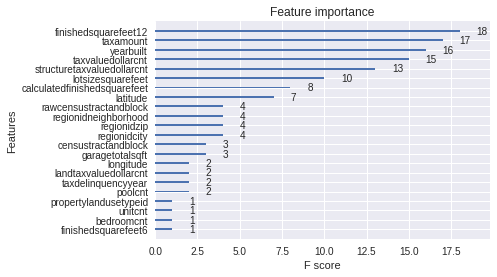

In [16]:
fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

xgb.plot_importance(clf)

plt.show()

## 二、DEA（数据可视化和异常值处理）

### feature = logerror

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
5   -0.2705
6    0.0440
7    0.1638
8   -0.0030
9    0.0843
Name: logerror, dtype: float64
0


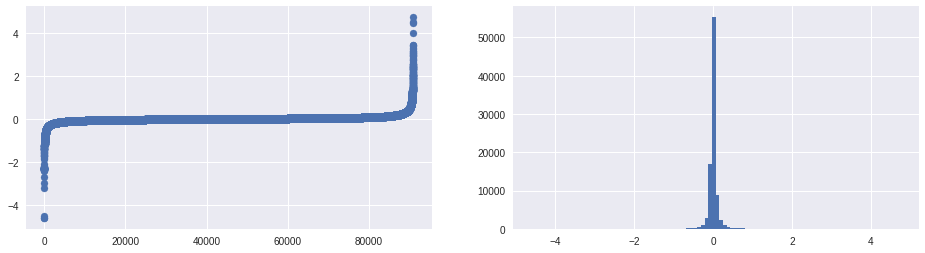

In [39]:
feature = 'logerror'

print train_df[feature][:10]
print train_df[feature].isnull().sum()

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(range(train.shape[0]),np.sort(train[feature].values))

# train = train[train[feature] > -0.4]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    1684.0
1    2263.0
2    2217.0
3     839.0
4    2283.0
5    3067.0
6    1297.0
7    1763.0
8     796.0
9    1260.0
Name: finishedsquarefeet12, dtype: float32
0
count    90811.00000
mean      1745.39209
std        883.41803
min          2.00000
25%       1193.00000
50%       1567.00000
75%       2008.00000
max      20013.00000
Name: finishedsquarefeet12, dtype: float64


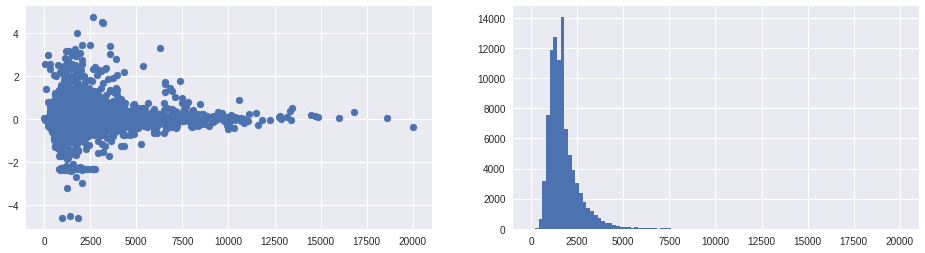

In [54]:
feature = 'finishedsquarefeet12'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

# train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)

# train = train[train[feature] > 7500]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0     6735.879883
1    10153.019531
2    11484.480469
3     3048.739990
4     5488.959961
5    27126.570312
6     2304.969971
7     3745.500000
8     2172.879883
9     1940.260010
Name: taxamount, dtype: float32
0
count     90811.000000
mean       5983.961426
std        6818.360352
min          49.080002
25%        2884.155029
50%        4563.799805
75%        6881.864990
max      321936.093750
Name: taxamount, dtype: float64


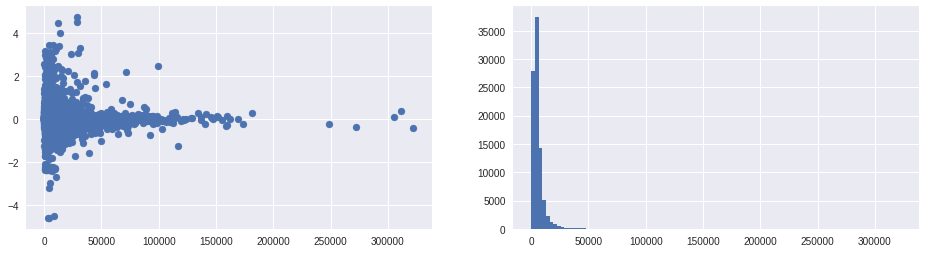

In [55]:
feature = 'taxamount'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

#train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)


# train = train[train[feature] > 2000000]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    1959.0
1    2014.0
2    1940.0
3    1987.0
4    1981.0
5    1982.0
6    1939.0
7    1994.0
8    1984.0
9    1977.0
Name: yearbuilt, dtype: float32
0
count    90811.000000
mean      1968.402588
std         23.593706
min       1885.000000
25%       1953.000000
50%       1969.000000
75%       1986.000000
max       2015.000000
Name: yearbuilt, dtype: float64


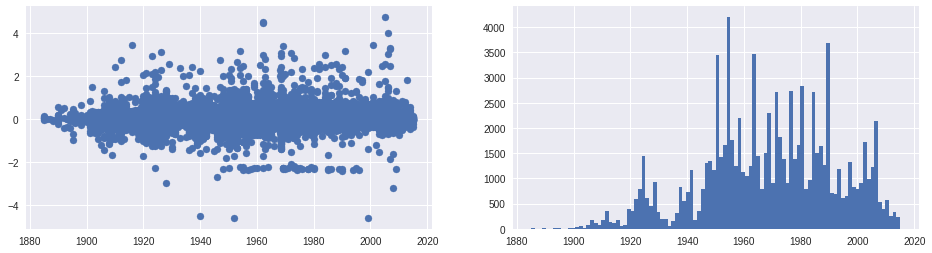

In [56]:
feature = 'yearbuilt'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)


# train = train[train[feature] > -0.4]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    122754.0
1    346458.0
2     61994.0
3    171518.0
4    169574.0
5    880650.0
6     64549.0
7    107000.0
8     66834.0
9    109977.0
Name: structuretaxvaluedollarcnt, dtype: float32
0
count    9.081100e+04
mean     1.800914e+05
std      2.080702e+05
min      1.000000e+02
25%      8.178800e+04
50%      1.331990e+05
75%      2.093270e+05
max      9.948100e+06
Name: structuretaxvaluedollarcnt, dtype: float64


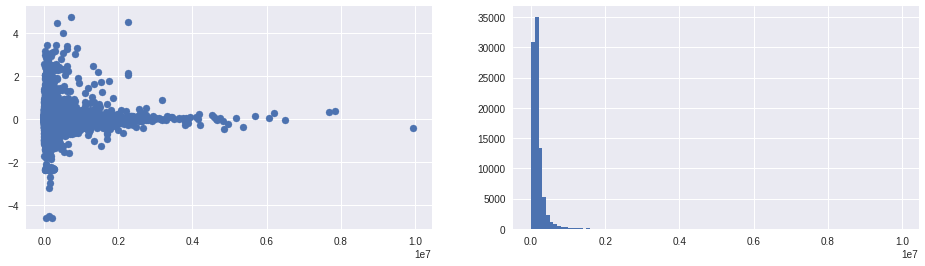

In [57]:
feature = 'structuretaxvaluedollarcnt'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)


# train = train[train[feature] > -0.4]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0     7528.000000
1     3643.000000
2    11423.000000
3    70859.000000
4     6000.000000
5     2708.000000
6     6677.000000
7    29110.482422
8    29110.482422
9    29110.482422
Name: lotsizesquarefeet, dtype: float32
0
count    9.081100e+04
mean     2.910922e+04
std      1.143362e+05
min      1.670000e+02
25%      5.973000e+03
50%      7.600000e+03
75%      2.323800e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64


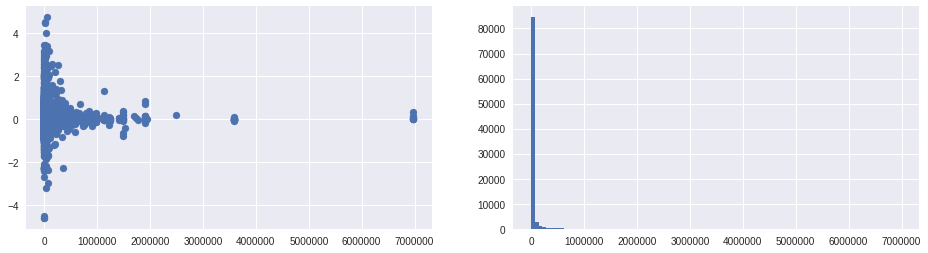

In [58]:
feature = 'lotsizesquarefeet'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)


# train = train[train[feature] > 20000000]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    1684.0
1    2263.0
2    2217.0
3     839.0
4    2283.0
5    3067.0
6    1297.0
7    1763.0
8     796.0
9    1260.0
Name: calculatedfinishedsquarefeet, dtype: float32
0
count    90811.000000
mean      1773.198730
std        922.016174
min          2.000000
25%       1189.000000
50%       1551.000000
75%       2084.000000
max      22741.000000
Name: calculatedfinishedsquarefeet, dtype: float64


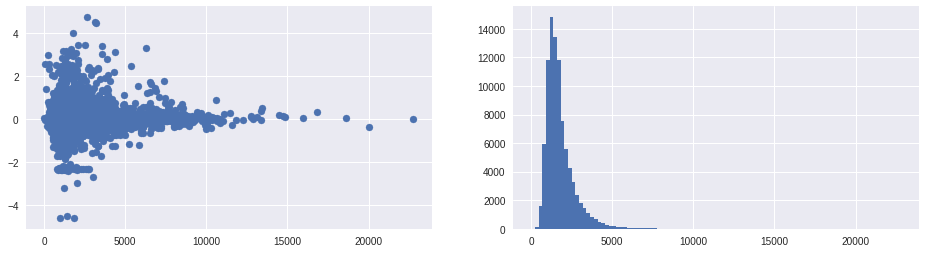

In [59]:
feature = 'calculatedfinishedsquarefeet'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].values,train["logerror"].values)


# train = train[train[feature] > 150000]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    34280992.0
1    33668120.0
2    34136312.0
3    33755800.0
4    33485644.0
5    33870088.0
6    33899476.0
7    34207204.0
8    33549600.0
9    33612700.0
Name: latitude, dtype: float32
536
count    9.027500e+04
mean     3.400396e+07
std      2.649669e+05
min      3.333930e+07
25%      3.381154e+07
50%      3.402150e+07
75%      3.417274e+07
max      3.481601e+07
Name: latitude, dtype: float64


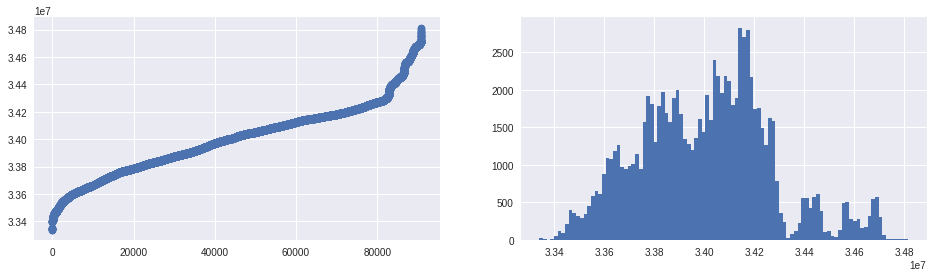

In [52]:
feature = 'latitude'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(range(train.shape[0]),np.sort(train[feature].values))


# train = train[train[feature] > -0.4]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    1684.0
1    2263.0
2    2217.0
3     839.0
4    2283.0
5    3067.0
6    1297.0
7    1763.0
8     796.0
9    1260.0
Name: calculatedfinishedsquarefeet, dtype: float32
0
count    90811.000000
mean      1773.198730
std        922.016174
min          2.000000
25%       1189.000000
50%       1551.000000
75%       2084.000000
max      22741.000000
Name: calculatedfinishedsquarefeet, dtype: float64


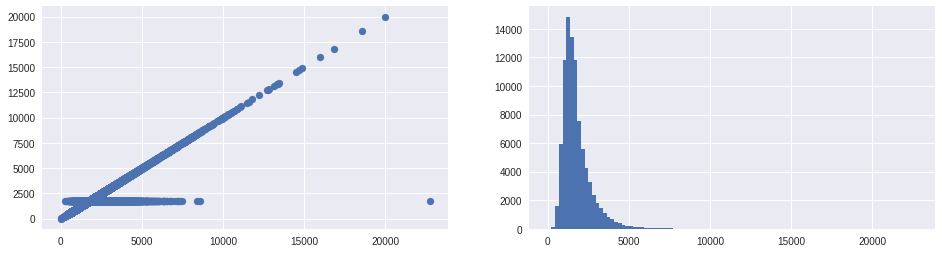

In [60]:
feature = 'calculatedfinishedsquarefeet'

print train[feature][:10]
print train[feature].isnull().sum()
print train[feature].describe()

#train[feature] = train[feature].fillna(train[feature].mean())

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(train[feature].notnull().values,train['finishedsquarefeet12'].values)


# train = train[train[feature] > -0.4]
# train = train[train[feature] < 0.4]

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

### feature = transactiondate

In [35]:
feature = 'transactiondate'

print train_df[feature][:10]
print train_df[feature].isnull().sum()
print train_df[feature].mean()

fig = plt.figure()
fig.set(alpha=0.2)
fig.set_size_inches(16, 9)

plt.subplot2grid((2,2),(0,0))
plt.scatter(range(train.shape[0]),np.sort(train[feature].values))

plt.subplot2grid((2,2),(0,1))
plt.hist(train[feature].values,bins=100)

fig.show()

0    2016-01-01
1    2016-01-01
2    2016-01-01
3    2016-01-02
4    2016-01-02
5    2016-01-02
6    2016-01-02
7    2016-01-02
8    2016-01-02
9    2016-01-03
Name: transactiondate, dtype: object
0


TypeError: Could not convert 2016-01-012016-01-012016-01-012016-01-022016-01-022016-01-022016-01-022016-01-022016-01-022016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-032016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-042016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-052016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-062016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-072016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-082016-01-092016-01-092016-01-092016-01-092016-01-092016-01-092016-01-092016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-102016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-112016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-122016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-132016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-142016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-152016-01-162016-01-172016-01-172016-01-172016-01-172016-01-172016-01-172016-01-172016-01-172016-01-172016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-182016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-192016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-202016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-212016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-222016-01-232016-01-232016-01-232016-01-232016-01-232016-01-232016-01-232016-01-232016-01-232016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-242016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-252016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-262016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-272016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-282016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-292016-01-302016-01-302016-01-302016-01-302016-01-302016-01-302016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-01-312016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-012016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-022016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-032016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-042016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-052016-02-062016-02-062016-02-062016-02-062016-02-062016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-072016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-082016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-092016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-102016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-112016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-122016-02-132016-02-132016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-142016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-152016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-162016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-172016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-182016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-192016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-202016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-212016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-222016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-232016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-242016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-252016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-262016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-272016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-282016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-02-292016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-012016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-022016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-032016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-042016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-052016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-062016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-072016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-082016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-092016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-102016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-112016-03-132016-03-132016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-142016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-152016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-162016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-172016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-182016-03-192016-03-192016-03-192016-03-202016-03-202016-03-202016-03-202016-03-202016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-212016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-222016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-232016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-242016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-252016-03-272016-03-272016-03-272016-03-272016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-282016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-292016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-302016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-03-312016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-012016-04-022016-04-022016-04-032016-04-032016-04-032016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-042016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-052016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-062016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-072016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-082016-04-092016-04-092016-04-092016-04-092016-04-092016-04-102016-04-102016-04-102016-04-102016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-112016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-122016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-132016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-142016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-152016-04-162016-04-162016-04-172016-04-172016-04-172016-04-172016-04-172016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-182016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-192016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-202016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-212016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-222016-04-232016-04-232016-04-232016-04-232016-04-232016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-242016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-252016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-262016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-272016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-282016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-292016-04-302016-04-302016-04-302016-04-302016-04-302016-04-302016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-012016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-022016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-032016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-042016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-052016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-062016-05-072016-05-072016-05-072016-05-082016-05-082016-05-082016-05-082016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-092016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-102016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-112016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-122016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-132016-05-142016-05-142016-05-142016-05-142016-05-142016-05-152016-05-152016-05-152016-05-152016-05-152016-05-152016-05-152016-05-152016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-162016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-172016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-182016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-192016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-202016-05-222016-05-222016-05-222016-05-222016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-232016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-242016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-252016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-262016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-272016-05-282016-05-282016-05-282016-05-292016-05-292016-05-292016-05-292016-05-292016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-302016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-05-312016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-012016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-022016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-032016-06-042016-06-042016-06-042016-06-042016-06-042016-06-042016-06-052016-06-052016-06-052016-06-052016-06-052016-06-052016-06-052016-06-052016-06-052016-06-052016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-062016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-072016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-082016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-092016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-102016-06-112016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-122016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-132016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-142016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-152016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-162016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-172016-06-182016-06-182016-06-182016-06-192016-06-192016-06-192016-06-192016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-202016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-212016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-222016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-232016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-242016-06-252016-06-252016-06-262016-06-262016-06-262016-06-262016-06-262016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-272016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-282016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-292016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-06-302016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-012016-07-022016-07-022016-07-022016-07-022016-07-022016-07-042016-07-042016-07-042016-07-042016-07-042016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-052016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-062016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-072016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-082016-07-092016-07-092016-07-102016-07-102016-07-102016-07-102016-07-102016-07-102016-07-102016-07-102016-07-102016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-112016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-122016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-132016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-142016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-152016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-162016-07-172016-07-172016-07-172016-07-172016-07-172016-07-172016-07-172016-07-172016-07-172016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-182016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-192016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-202016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-212016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-222016-07-232016-07-232016-07-232016-07-232016-07-232016-07-242016-07-242016-07-242016-07-242016-07-242016-07-242016-07-242016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-252016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-262016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-272016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-282016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-292016-07-302016-07-302016-07-302016-07-302016-07-302016-07-302016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-07-312016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-012016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-022016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-032016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-042016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-052016-08-062016-08-062016-08-062016-08-072016-08-072016-08-072016-08-072016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-082016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-092016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-102016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-112016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-122016-08-132016-08-132016-08-132016-08-142016-08-142016-08-142016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-152016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-162016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-172016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-182016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-192016-08-202016-08-202016-08-202016-08-202016-08-202016-08-212016-08-212016-08-212016-08-212016-08-212016-08-212016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-222016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-232016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-242016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-252016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-262016-08-272016-08-272016-08-272016-08-272016-08-272016-08-282016-08-282016-08-282016-08-282016-08-282016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-292016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-302016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-08-312016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-012016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-022016-09-032016-09-032016-09-032016-09-042016-09-042016-09-042016-09-042016-09-052016-09-052016-09-052016-09-052016-09-052016-09-052016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-062016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-072016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-082016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-092016-09-102016-09-102016-09-102016-09-102016-09-102016-09-112016-09-112016-09-112016-09-112016-09-112016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-122016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-132016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-142016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-152016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-162016-09-172016-09-172016-09-172016-09-172016-09-172016-09-172016-09-172016-09-172016-09-182016-09-182016-09-182016-09-182016-09-182016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-192016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-202016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-212016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-222016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-232016-09-242016-09-242016-09-242016-09-242016-09-252016-09-252016-09-252016-09-252016-09-252016-09-252016-09-252016-09-252016-09-252016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-262016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-272016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-282016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-292016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-09-302016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-012016-10-022016-10-022016-10-022016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-032016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-042016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-052016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-062016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-072016-10-082016-10-082016-10-082016-10-082016-10-082016-10-082016-10-082016-10-092016-10-092016-10-092016-10-092016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-102016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-112016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-122016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-132016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-142016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-172016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-182016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-192016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-202016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-212016-10-222016-10-222016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-242016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-252016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-262016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-272016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-282016-10-292016-10-292016-10-302016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-10-312016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-012016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-022016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-032016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-042016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-062016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-072016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-082016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-092016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-102016-11-122016-11-122016-11-122016-11-122016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-132016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-142016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-152016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-162016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-172016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-182016-11-192016-11-192016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-202016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-212016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-222016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-232016-11-242016-11-242016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-272016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-282016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-292016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-11-302016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-012016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-022016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-042016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-052016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-062016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-072016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-082016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-092016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-112016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-122016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-132016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-142016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-152016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-162016-12-172016-12-172016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-182016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-192016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-202016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-212016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-222016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-232016-12-242016-12-242016-12-252016-12-252016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-262016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-272016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-282016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-292016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-302016-12-30 to numeric

## 三、Feature Engineering（特征工程）

In [32]:
drop_feature = ['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'] 
#add transaction_month

for c in train.dtypes[train.dtypes == object].index.values:
    train[c] = (train[c] == True)
    
trainData, validData = train_test_split(train, test_size = 0.33, random_state=1)

x_train = trainData.drop(drop_feature,axis=1) 
y_train = trainData['logerror']

x_valid = validData.drop(drop_feature, axis=1)
y_valid = validData['logerror']

print x_train.shape, x_valid.shape

(62218, 55) (26666, 55)


In [33]:
xgb_train = xgb.DMatrix(x_train, label=y_train)
xgb_valid = xgb.DMatrix(x_valid, label=y_valid)

## 四、Train data

In [ ]:
params={
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'eta': 0.01,
    'max_depth':8,
    'min_child_weight':4, 
    'lambda': 0.2,
    'alpha':0.8,
    'silent':0 ,
    'seed':1000,
    'nthread':4,# cpu 线程数
}
watchlist = [(xgb_train, 'train'), (xgb_valid, 'valid')]
clf = xgb.train(params, xgb_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.487981	valid-mae:0.488611
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.441328	valid-mae:0.44196
[20]	train-mae:0.399135	valid-mae:0.399765
[30]	train-mae:0.361038	valid-mae:0.361666
[40]	train-mae:0.326755	valid-mae:0.327394
[50]	train-mae:0.295923	valid-mae:0.296625
[60]	train-mae:0.268234	valid-mae:0.268986
[70]	train-mae:0.243383	valid-mae:0.244175
[80]	train-mae:0.221108	valid-mae:0.22193
[90]	train-mae:0.201155	valid-mae:0.202004
[100]	train-mae:0.183304	valid-mae:0.184181
[110]	train-mae:0.167358	valid-mae:0.168251
[120]	train-mae:0.153118	valid-mae:0.15403
[130]	train-mae:0.140415	valid-mae:0.141359
[140]	train-mae:0.129103	valid-mae:0.130082
[150]	train-mae:0.119067	valid-mae:0.120066
[160]	train-mae:0.110174	valid-mae:0.111186
[170]	train-mae:0.10231	valid-mae:0.103332
[180]	train-mae:0.095375	valid-mae:0.096406
[190]	train-mae:0.089275	valid-mae:

## 五、Prediction

In [27]:
x_test = test[x_train.columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
xgb_test = xgb.DMatrix(x_test)

D:\SDE\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [28]:
p_test = clf.predict(xgb_test)

sub = pd.read_csv('data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('data/xgb.csv', index=False, float_format='%.4f') 

Writing csv ...
